In [1]:
from pathlib import Path
from typing import Literal

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec
from scipy.stats import spearmanr
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, matthews_corrcoef, roc_auc_score, accuracy_score

from src.downstream.utils import multioutput_mcc

## Static Variables

In [2]:
SPLIT = "valid"
SPLIT_ID = {"train": 0, "valid": 1, "test": 2}[SPLIT]

MODELS = ["esm_t6", "esm_t12", "esm_t30", "esm_t33", "esm_t36", "esmc_300m", "esmc_600m", "ankh-base", "ankh-large", "prostt5", "prott5", "ohe"]
DATASETS = ["fluorescence", "stability", "deeploc2", "deeploc2_bin", "esol"]
LAYERS = {
    "esm_t6": 6,
    "esm_t12": 12,
    "esm_t30": 30,
    "esm_t33": 33,
    "esm_t36": 36,
    "esmc_300m": 30,
    "esmc_600m": 36,
    "ankh-base": 48,
    "ankh-large": 48,
    "prostt5": 24,
    "prott5": 24,
    "ohe": 0,
}
MODEL_COLORS = {
    "esm_t6": "lightsteelblue",
    "esm_t12": "cornflowerblue",
    "esm_t30": "royalblue",
    "esm_t33": "mediumblue",
    "esm_t36": "darkblue",
    "esmc_300m": "lightblue",
    "esmc_600m": "blue",
    "ankh-base": "lime",
    "ankh-large": "darkgreen",
    "prostt5": "orangered",
    "prott5": "darkorange",
    "ohe": "gray",
}

REG_METRIC = "rmse"
CLASS_METRIC = "mcc"
ROOT = Path("/") / "scratch" / "SCRATCH_SAS" / "roman" / "SMTB" / "embeddings"

Path("figures").mkdir(exist_ok=True)


def kill_axis(ax):
    ax.set_axis_off()

## Code

first for general datasets, then for SCOPe40 2.08

In [3]:
with open(ROOT / "ankh-base" / "deeploc2" / "layer_0" / "predictions_lr_42.pkl", "rb") as f:
    y_hat, y = pd.read_pickle(f)[1]
print(roc_auc_score(y, np.array(y_hat)[:, :, 1].T, multi_class="ovr"))  # multilabel
print(multioutput_mcc(y, np.array(y_hat)[:, :, 1].T))

0.7467189598179136
0.13020929687507535


In [4]:
with open(ROOT / "ankh-base" / "deeploc2_bin" / "layer_0" / "predictions_lr_42.pkl", "rb") as f:
    y_hat, y = pd.read_pickle(f)[1]
print(roc_auc_score(y, y_hat, multi_class="ovr"))  # binary
print(matthews_corrcoef(y, y_hat > 0.5))

0.7474445833214972
0.39769735300621667


In [5]:
with open(ROOT / "ankh-base" / "scope_40_208" / "layer_0" / "predictions_lr_fold_4.pkl", "rb") as f:
    y_hat, y = pd.read_pickle(f)[1]
print(roc_auc_score(y, y_hat, multi_class="ovr"))  # multiclass
print(matthews_corrcoef(y, y_hat.argmax(axis=1)))

0.9368092796369931
0.6726863485727459


In [6]:
def compute_metric(root: Path = None, model = None, dataset = None, layer = None, algo = None, metric = None, filepath=None):
    if filepath is None:
        filepath = root / model / dataset / f"layer_{layer}" / f"predictions_{algo}_42.pkl"
    with open(filepath, "rb") as f:
        y_hat, y = pd.read_pickle(f)[SPLIT_ID]
        y_hat = np.array(y_hat)
        y = np.array(y)
    
    match metric.lower():
        case "pearson":
            return np.corrcoef(y_hat, y)[0, 1]
        case "spearman":
            return spearmanr(y_hat, y)[0]
        case "r2":
            return r2_score(y, y_hat)
        case "mse":
            return mean_squared_error(y, y_hat)
        case "mae":
            return mean_absolute_error(y, y_hat)
        case "rmse":
            return np.sqrt(mean_squared_error(y, y_hat))
        case "mcc":
            if y_hat.ndim == 3:  # multilabel
                return multioutput_mcc(y, np.array(y_hat)[:, :, 1].T)
            if y_hat.ndim == 2:
                return matthews_corrcoef(y, y_hat.argmax(axis=1))
            return matthews_corrcoef(y, y_hat > 0.5)
        case "auroc":
            if y_hat.ndim == 3:  # multilabel
                return roc_auc_score(y, np.array(y_hat)[:, :, 1].T, multi_class="ovr")
            return roc_auc_score(y, y_hat, multi_class="ovr")
        case _:
            raise ValueError(f"Unknown metric: {metric}")


def read_metric(root: Path, model, dataset, layer, metric: Literal["ids", "density", "noverlap", "noverlap_50"]):
    name_map = {"ids": "twonn_id", "density": "density", "noverlap": "neighbor_overlap", "noverlap_50": "neighbor_overlap"}
    if dataset == "deeploc2_bin":
        dataset = "deeploc2"
    filepath = root / model / dataset / f"layer_{layer}" / f"{'noverlap_10' if metric == 'noverlap' else metric}.csv"
    if not filepath.exists():
        return 0
    df = pd.read_csv(filepath)
    return df[name_map[metric]].values[0]


def get_baseline(root: Path, dataset, algo, metric):
    return compute_metric(root, "ohe", dataset, 0, algo, metric)


def plot_performance(ax, root, dataset, algo, metric, relative, legend: bool = False):
    # baseline = get_baseline(root, dataset, algo, metric)
    # ax.axhline(baseline, linestyle="--", label="OHE Baseline")
    for model in MODELS[:-1]:
        if dataset == "esol" and algo == "lr" and model == "esm_t36":
            continue  # weird embeddings data
        perfs = []
        for layer in range(LAYERS[model] + 1):
            result = compute_metric(root, model, dataset, layer, algo, metric)
            perfs.append(result)
        if relative:
            ax.plot(np.arange(0, 1 + 1e-5, 1 / (LAYERS[model])), perfs, label=model, c=MODEL_COLORS.get(model, None))
        else:
            ax.plot(perfs, label=model, c=MODEL_COLORS.get(model, None))

    ax.set_xlabel(("Relative" if relative else "Absolute") + " Layer")
    ax.set_ylabel(metric.upper())
    ax.set_title(f"{metric.upper()} of {algo.upper()} heads")
    if legend:
        ax.legend()


def plot_metric(ax, root, dataset, relative, legend: bool = False, metric: Literal["ids", "density", "noverlap", "noverlap_50"] = "ids"):
    title_map = {"ids": "Intrinsic Dimensions", "density": "Density", "noverlap": "Neighbor Overlap (10)", "noverlap_50": "Neighbor Overlap (50)"}
    # if not metric.startswith("noverlap"):
    #     baseline = read_metric(root, "ohe", dataset, 0, metric)
    #     ax.axhline(baseline, linestyle="--", label="OHE Baseline")
    for model in MODELS[:-1]:
        perfs = []
        for layer in range(LAYERS[model] + 1):
            if metric.startswith("noverlap") and layer == LAYERS[model]:
                continue
            result = read_metric(root, model, dataset, layer, metric)
            perfs.append(result)
        if relative:
            x_ticks = np.arange(0, 1 + 1e-5, 1 / (LAYERS[model]))
            if metric.startswith("noverlap"):
                x_ticks = x_ticks[:-1]
                x_ticks += 1 / (2 * LAYERS[model])
            ax.plot(x_ticks, perfs, label=model, c=MODEL_COLORS.get(model, None))
        else:
            ax.plot(perfs, label=model, c=MODEL_COLORS.get(model, None))

    ax.set_xlabel(("Relative" if relative else "Absolute") + " Layer")
    ax.set_ylabel(title_map[metric])
    ax.set_title(f"{title_map[metric]}")
    if legend:
        ax.legend(loc="upper right")


def plot_empty(ax, root, dataset, models, algo, metric, relative: bool = True, legend: bool = False):
    if isinstance(models, str):
        models = [models]

    for model in models:
        for prefix in ["empty_", ""]:
            perfs = []
            for layer in range(LAYERS[model] + 1):
                # if metric.startswith("noverlap") and layer == LAYERS[model]:
                #     continue
                result = compute_metric(root, prefix + model, dataset, layer, algo, metric)
                perfs.append(result)
            if relative:
                ax.plot(np.arange(0, 1 + 1e-5, 1 / (LAYERS[model])), perfs, label=prefix + model, color=MODEL_COLORS.get(model, None), linestyle="--" if prefix == "empty_" else "-")
            else:
                ax.plot(perfs, label=prefix + model, color=MODEL_COLORS.get(model, None), linestyle="--" if prefix == "empty_" else "-")
    
    ax.set_xlabel(("Relative" if relative else "Absolute") + " Layer")
    ax.set_ylabel(metric.upper())
    ax.set_title(f"{metric.upper()} of {algo.upper()} heads on {dataset.capitalize()}")
    if legend:
        ax.legend()

In [7]:
def compute_scope_metric(root: Path, model, dataset, layer, algo, metric, level, k=None, min_x=None):
    assert (k is not None) != (min_x is not None), "Exactly one of k and min_x must be provided."
    with open(root / model / dataset / f"layer_{layer}" / f"predictions_{algo}_{level}_{k if k is not None else f'min{min_x}'}.pkl", "rb") as f:
        y_hat, y = pd.read_pickle(f)[1]
    match metric.lower():
        case "mcc":
            if y_hat.ndim == 3:  # multilabel
                return multioutput_mcc(y, np.array(y_hat)[:, :, 1].T)
            if y_hat.ndim == 2:
                return matthews_corrcoef(y, y_hat.argmax(axis=1))
            return matthews_corrcoef(y, y_hat > 0.5)
        case "auroc":
            if y_hat.ndim == 3:  # multilabel
                return roc_auc_score(y, np.array(y_hat)[:, :, 1].T, multi_class="ovr")
            return roc_auc_score(y, y_hat, multi_class="ovr")
        case "acc":
            return accuracy_score(y, y_hat)
        case _:
            raise ValueError(f"Unknown metric: {metric}")


def plot_scope_top4_metric(ax, algorithm, metric, level, relative):
    for model in MODELS[:-1]:
        if model.startswith("esmc"):
            continue
        perfs = []
        for layer in range(LAYERS[model] + 1):
            result = compute_scope_metric(ROOT, model, "scope_40_208", layer, algorithm, metric, level, k=4)
            perfs.append(result)
        if relative:
            ax.plot(np.arange(0, 1 + 1e-5, 1 / (LAYERS[model])), perfs, label=model, color=MODEL_COLORS.get(model, None))
        else:
            ax.plot(perfs, label=model, color=MODEL_COLORS.get(model, None))

    ax.set_xlabel(("Relative" if relative else "Absolute") + " Layer")
    ax.set_ylabel(metric.upper())
    ax.set_title(f"{metric.upper()} of {algorithm.upper()} heads ({level.capitalize()} Top-4)")


def plot_scope_topX_metric(ax, model, algorithm, metric, level, relative, correlation: bool = False):
    for k in [4, 6, 8, 10, 15, 20]:
        perfs = []
        for layer in range(LAYERS[model] + 1):
            if correlation:
                spearman, pearson = read_correlations(ROOT, model, layer, level, k)
                result = spearman if metric == "spearman" else pearson
            else:
                result = compute_scope_metric(ROOT, model, "scope_40_208", layer, algorithm, metric, level, k)
            perfs.append(result)
        if relative:
            ax.plot(np.arange(0, 1 + 1e-5, 1 / (LAYERS[model])), perfs, label=f"Top {k}")  # , c=MODEL_COLORS.get(model, None))
        else:
            ax.plot(perfs, label=model)  # , c=MODEL_COLORS.get(model, None))

    model_map = {
        "prostt5": "ProstT5",
        "prott5": "ProtT5",
        "ankh-large": "Ankh-large",
    }
    metric_map = {
        "mcc": "MCC",
        "spearman": "Spearman",
        "pearson": "Pearson",
    }
    ax.set_xlabel(("Relative" if relative else "Absolute") + " Layer")
    ax.set_ylabel(metric_map[metric])
    ax.set_title(f"{metric_map[metric]} of {algorithm.upper()} heads ({model_map[model]})")


def read_correlations(root: Path, model, layer, level, k):
    with open(root / model / "scope_40_208" / f"layer_{layer}" / f"correlations_{level}_{k}.csv", "rb") as f:
        corrs = pd.read_csv(f)
    return corrs["spearman"].values[0], corrs["pearson"].values[0]


def plot_scope_minx_metric(ax, algorithm, metric, level, relative):
    for model in MODELS[:-1]:
        if model.startswith("esmc"):
            continue
        perfs = []
        for layer in range(LAYERS[model] + 1):
            result = compute_scope_metric(ROOT, model, "scope_40_208", layer, algorithm, metric, level, min_x=10)
            perfs.append(result)
        if relative:
            ax.plot(np.arange(0, 1 + 1e-5, 1 / (LAYERS[model])), perfs, label=model, color=MODEL_COLORS.get(model, None))
        else:
            ax.plot(perfs, label=model, color=MODEL_COLORS.get(model, None))
    
    ax.set_xlabel(("Relative" if relative else "Absolute") + " Layer")
    ax.set_ylabel(metric.upper())
    ax.set_title(f"{metric.upper()} of {algorithm.upper()} heads ({level.capitalize()} Min-10)")


def plot_empty_scope(ax, root, dataset, models, algo, metric, level, relative: bool = True, legend: bool = False):
    if isinstance(models, str):
        models = [models]

    for model in models:
        for prefix in ["empty_", ""]:
            perfs = []
            for layer in range(LAYERS[model] + 1):
                # if metric.startswith("noverlap") and layer == LAYERS[model]:
                #     continue
                result = compute_scope_metric(root, prefix + model, dataset, layer, algo, metric, level, min_x=10)
                perfs.append(result)
            if relative:
                ax.plot(np.arange(0, 1 + 1e-5, 1 / (LAYERS[model])), perfs, label=prefix + model, color=MODEL_COLORS.get(model, None), linestyle="--" if prefix == "empty_" else "-")
            else:
                ax.plot(perfs, label=prefix + model, color=MODEL_COLORS.get(model, None), linestyle="--" if prefix == "empty_" else "-")
    
    ax.set_xlabel(("Relative" if relative else "Absolute") + " Layer")
    ax.set_ylabel(metric.upper())
    ax.set_title(f"{metric.upper()} of {algo.upper()} heads on {dataset.capitalize()}")
    if legend:
        ax.legend()

## Plots on diverse Protein Datasets

Plotting analysis for fluorescence...


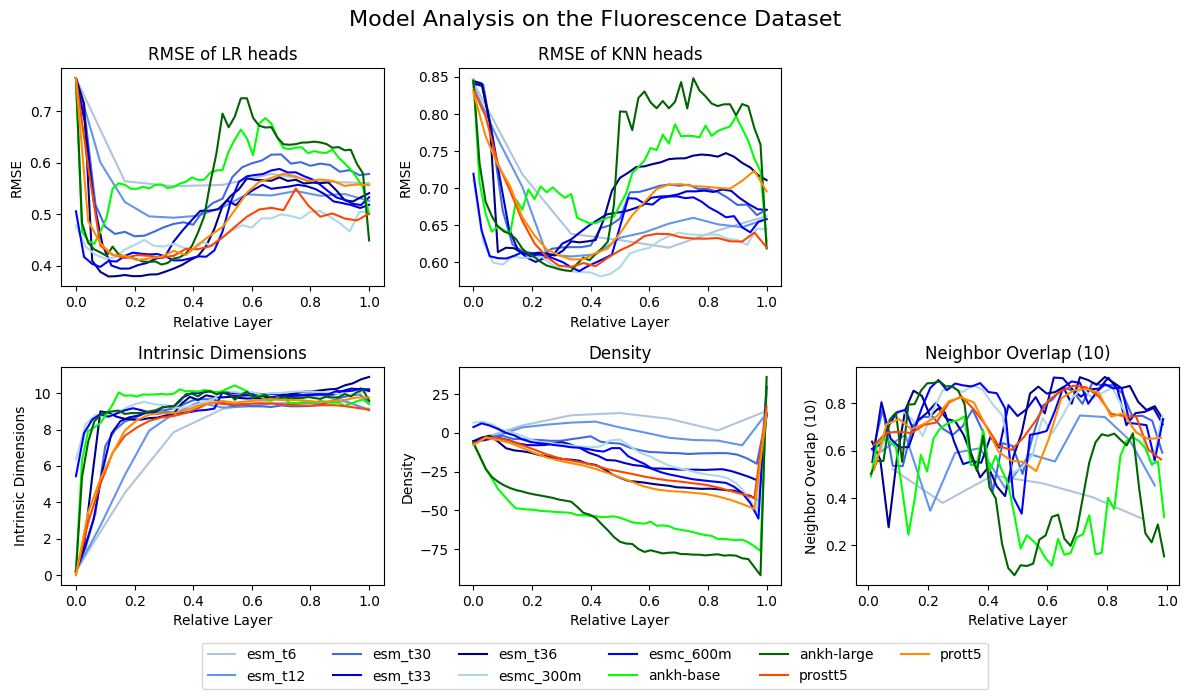

Plotting analysis for stability...


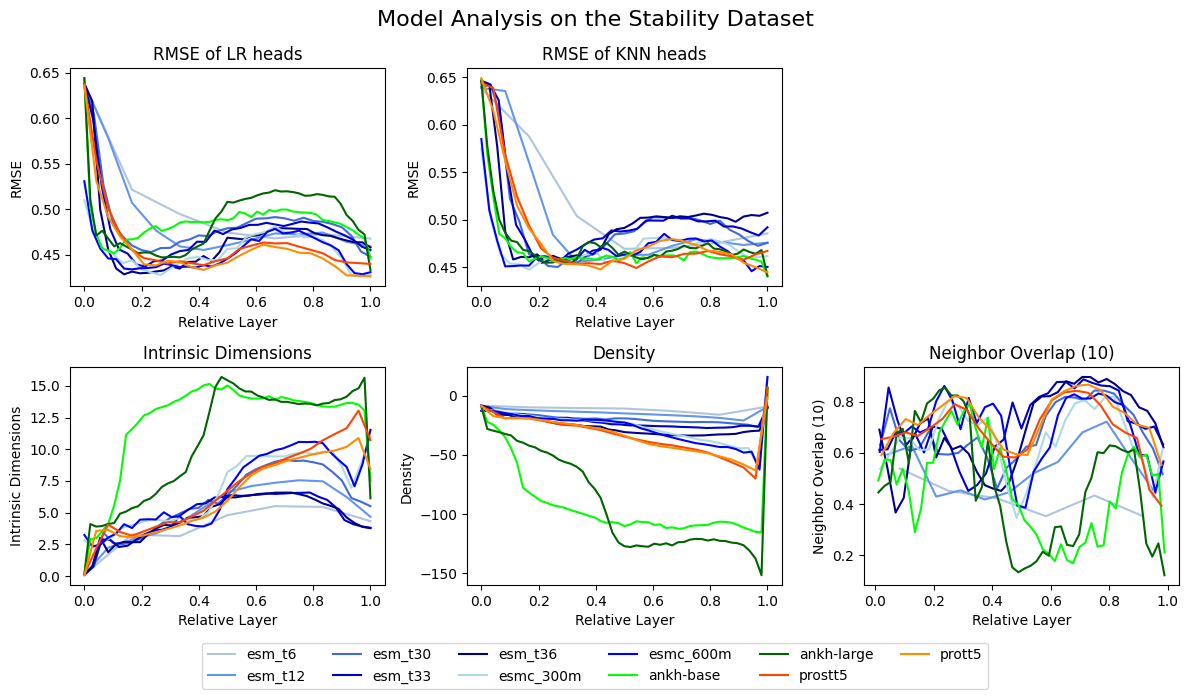

Plotting analysis for deeploc2...


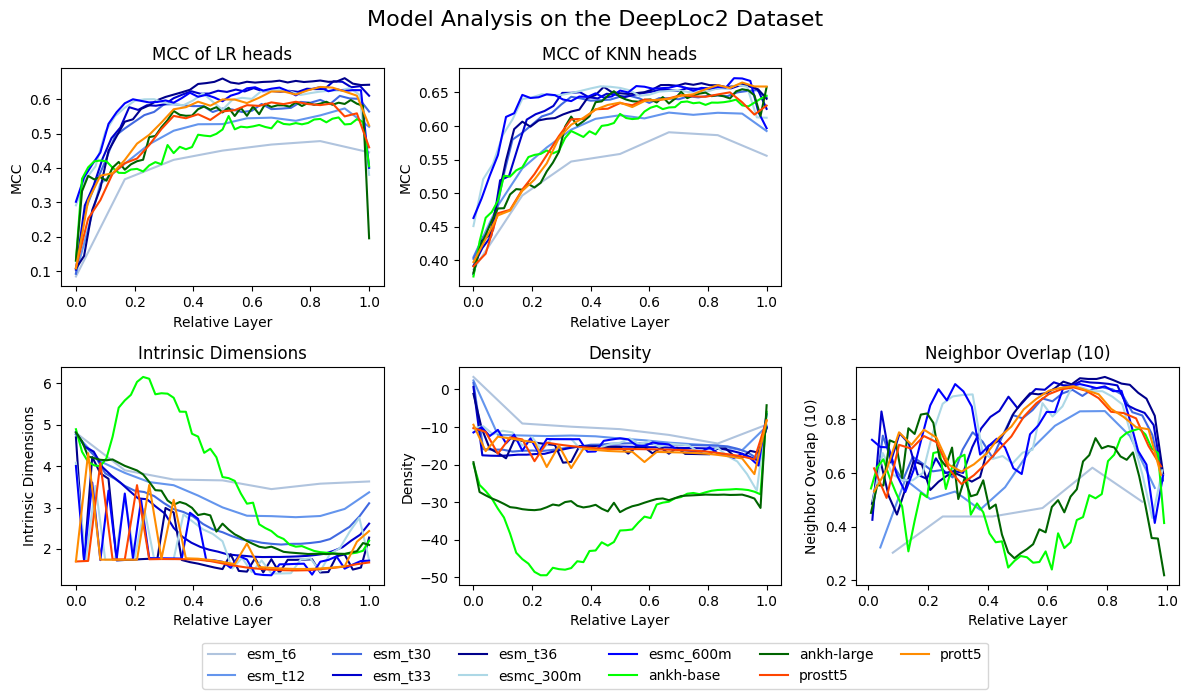

Plotting analysis for deeploc2_bin...


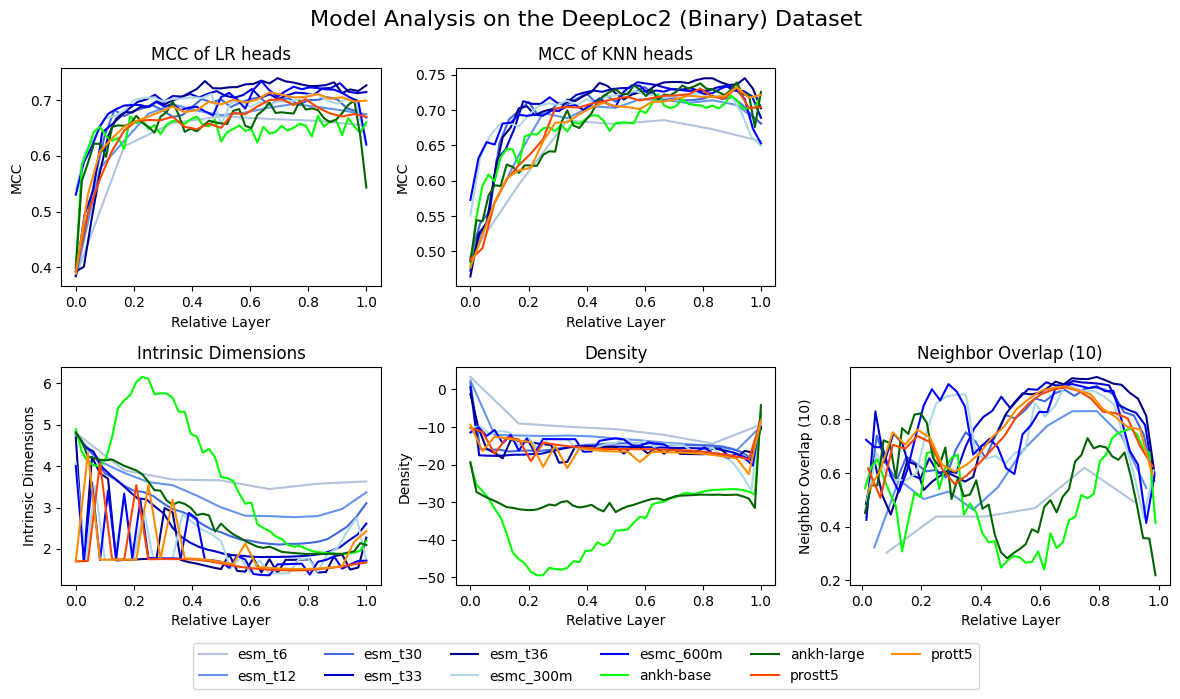

Plotting analysis for esol...


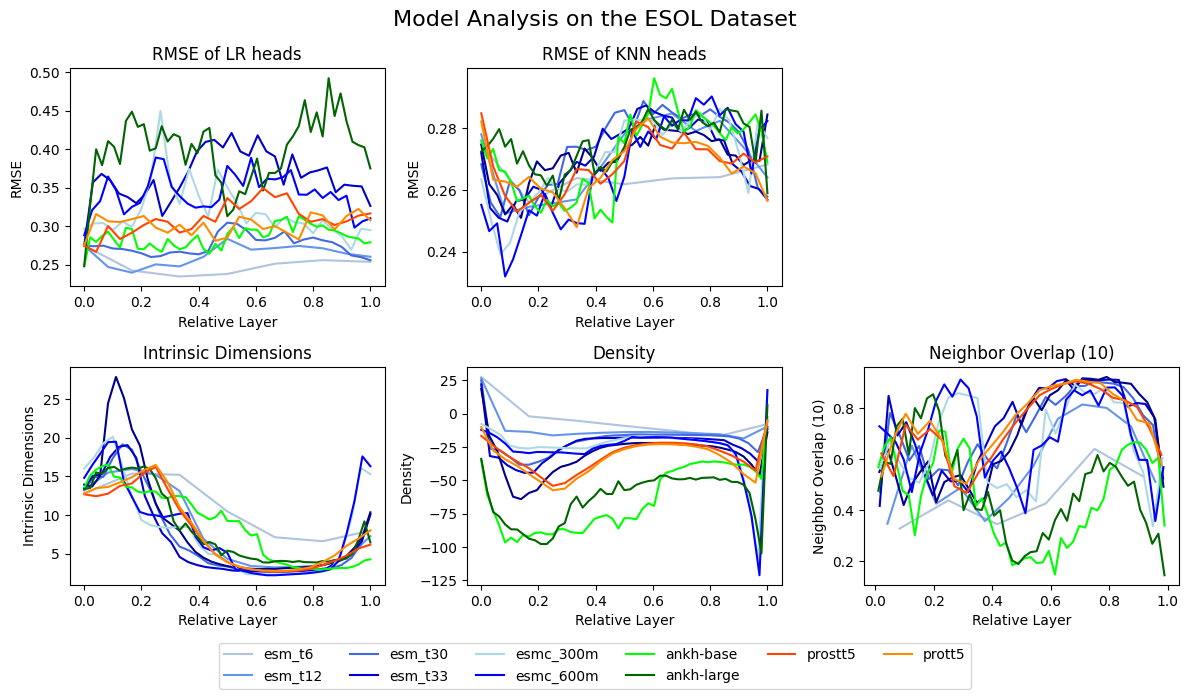

In [8]:
for dataset in DATASETS:
    print(f"Plotting analysis for {dataset}...")
    fig = plt.figure(figsize=(12, 7))
    gs = gridspec.GridSpec(2, 3, figure=fig)
    axs = [
        fig.add_subplot(gs[0, 0]), fig.add_subplot(gs[0, 1]), fig.add_subplot(gs[0, 2]),
        fig.add_subplot(gs[1, 0]), fig.add_subplot(gs[1, 1]), fig.add_subplot(gs[1, 2]),
    ]

    plot_performance(axs[0], ROOT, dataset, "lr", CLASS_METRIC if dataset.startswith("deeploc2") else REG_METRIC, relative=True, legend=False)
    plot_performance(axs[1], ROOT, dataset, "knn", CLASS_METRIC if dataset.startswith("deeploc2") else REG_METRIC, relative=True, legend=False)
    axs[2].set_axis_off()
    plot_metric(axs[3], ROOT, dataset, relative=True, legend=False, metric="ids")
    plot_metric(axs[4], ROOT, dataset, relative=True, legend=False, metric="density")
    plot_metric(axs[5], ROOT, dataset, relative=True, legend=False, metric="noverlap")

    handles, labels = axs[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc="lower center", bbox_to_anchor=(0.5, 0), bbox_transform=fig.transFigure, ncol=(len(MODELS) + 1) // 2)  # -0.08

    name_map = {
        "fluorescence": "Fluorescence",
        "stability": "Stability",
        "deeploc2": "DeepLoc2",
        "deeploc2_bin": "DeepLoc2 (Binary)",
        "esol": "ESOL",
    }

    fig.suptitle(f"Model Analysis on the {name_map[dataset]} Dataset", fontsize=16)
    plt.tight_layout(rect=[0, 0.075, 1, 1])
    plt.savefig(f"figures/{dataset}_analysis.pdf")
    plt.savefig(f"figures/{dataset}_analysis.png")
    plt.show()

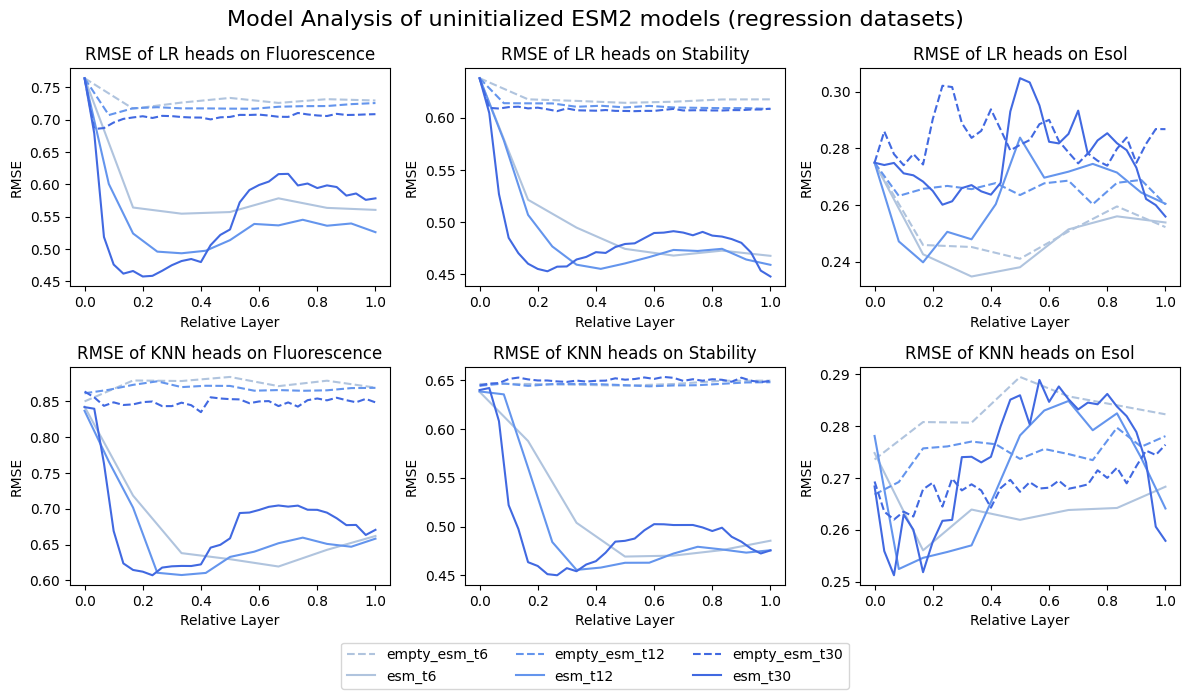

In [9]:
fig = plt.figure(figsize=(12, 7))
gs = gridspec.GridSpec(2, 3, figure=fig)
axs = [
    fig.add_subplot(gs[0, 0]), fig.add_subplot(gs[0, 1]), fig.add_subplot(gs[0, 2]),
    fig.add_subplot(gs[1, 0]), fig.add_subplot(gs[1, 1]), fig.add_subplot(gs[1, 2]),
]

plot_empty(axs[0], ROOT, "fluorescence", ["esm_t6", "esm_t12", "esm_t30"], "lr", REG_METRIC)
plot_empty(axs[1], ROOT, "stability", ["esm_t6", "esm_t12", "esm_t30"], "lr", REG_METRIC)
plot_empty(axs[2], ROOT, "esol", ["esm_t6", "esm_t12", "esm_t30"], "lr", REG_METRIC)
plot_empty(axs[3], ROOT, "fluorescence", ["esm_t6", "esm_t12", "esm_t30"], "knn", REG_METRIC)
plot_empty(axs[4], ROOT, "stability", ["esm_t6", "esm_t12", "esm_t30"], "knn", REG_METRIC)
plot_empty(axs[5], ROOT, "esol", ["esm_t6", "esm_t12", "esm_t30"], "knn", REG_METRIC)

handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="lower center", bbox_to_anchor=(0.5, 0), bbox_transform=fig.transFigure, ncol=3)  # -0.08

fig.suptitle(f"Model Analysis of uninitialized ESM2 models (regression datasets)", fontsize=16)
plt.tight_layout(rect=[0, 0.075, 1, 1])
plt.savefig(f"figures/empty_analysis_1.pdf")
plt.savefig(f"figures/empty_analysis_1.png")
plt.show()

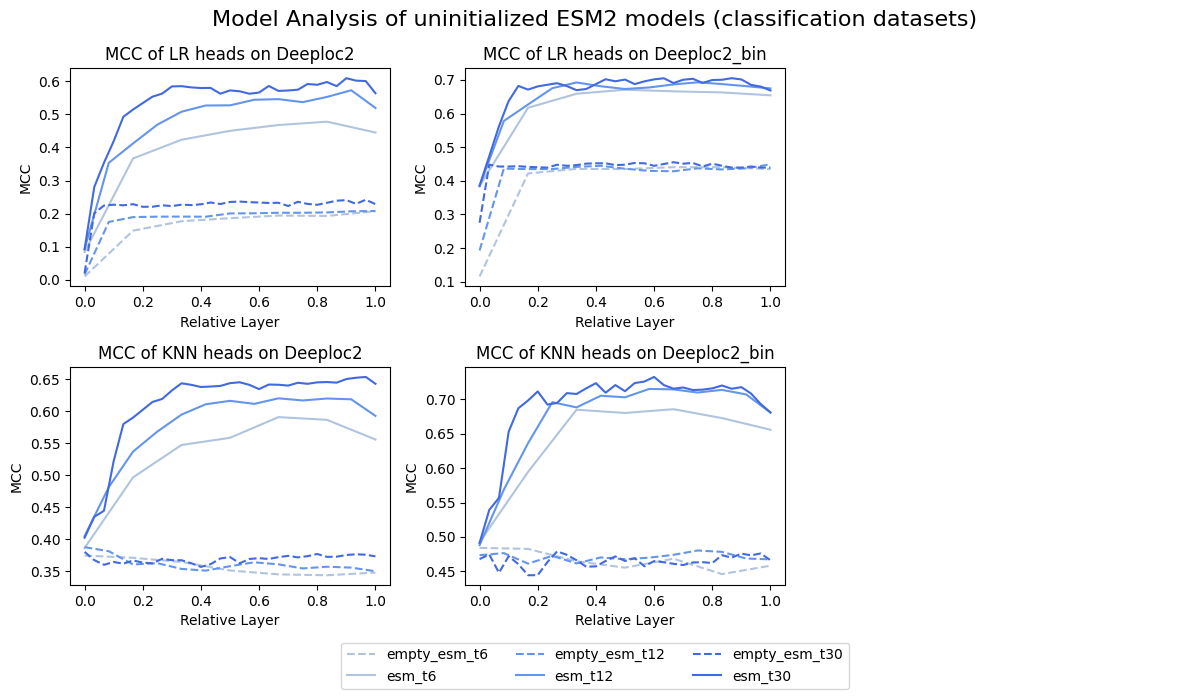

In [10]:
fig = plt.figure(figsize=(12, 7))
gs = gridspec.GridSpec(2, 3, figure=fig)
axs = [
    fig.add_subplot(gs[0, 0]), fig.add_subplot(gs[0, 1]), fig.add_subplot(gs[0, 2]),
    fig.add_subplot(gs[1, 0]), fig.add_subplot(gs[1, 1]), fig.add_subplot(gs[1, 2]),
]

plot_empty(axs[0], ROOT, "deeploc2", ["esm_t6", "esm_t12", "esm_t30"], "lr", CLASS_METRIC)
plot_empty(axs[1], ROOT, "deeploc2_bin", ["esm_t6", "esm_t12", "esm_t30"], "lr", CLASS_METRIC)
kill_axis(axs[2])
plot_empty(axs[3], ROOT, "deeploc2", ["esm_t6", "esm_t12", "esm_t30"], "knn", CLASS_METRIC)
plot_empty(axs[4], ROOT, "deeploc2_bin", ["esm_t6", "esm_t12", "esm_t30"], "knn", CLASS_METRIC)
kill_axis(axs[5])

handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="lower center", bbox_to_anchor=(0.5, 0), bbox_transform=fig.transFigure, ncol=3)  # -0.08


fig.suptitle(f"Model Analysis of uninitialized ESM2 models (classification datasets)", fontsize=16)
plt.tight_layout(rect=[0, 0.075, 1, 1])
plt.savefig(f"figures/empty_analysis_2.pdf")
plt.savefig(f"figures/empty_analysis_2.png")
plt.show()

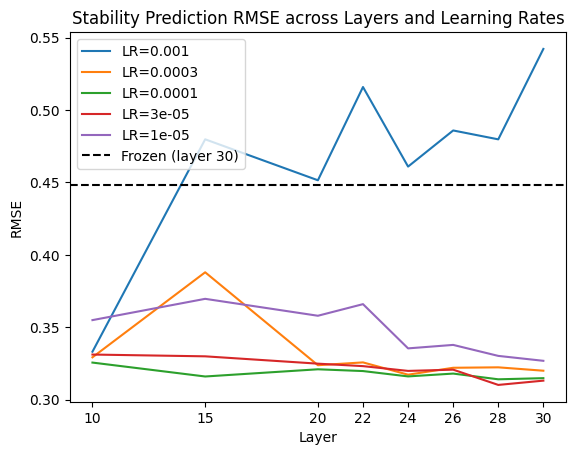

In [11]:
df = pd.DataFrame(columns=["10", "15", "20", "22", "24", "26", "28", "30"], index=["0.001", "0.0003", "0.0001", "3e-05", "1e-05"])
for lr in df.index:
    for layer in df.columns:
        if not (ROOT / "esm_t30" / "stability" / f"predictions_unfrozen_esm_t30_{layer}_30_{lr}.pkl").exists():
            continue
        metric = compute_metric(algo="lr", metric=REG_METRIC, filepath=ROOT / "esm_t30" / "stability" / f"predictions_unfrozen_esm_t30_{layer}_30_{lr}.pkl")
        df.loc[lr, layer] = metric

for lr in df.index:
    plt.plot(df.columns.astype(int), df.loc[lr].astype(float), label=f"LR={lr}")

baseline = compute_metric(root=ROOT, model="esm_t30", dataset="stability", layer=30, algo="lr", metric=REG_METRIC)
plt.axhline(baseline, linestyle="--", label="Frozen (layer 30)", color="black")

plt.xlabel("Layer")
plt.ylabel("RMSE")
plt.xticks([10, 15, 20, 22, 24, 26, 28, 30], labels=["10", "15", "20", "22", "24", "26", "28", "30"])
plt.title("Stability Prediction RMSE across Layers and Learning Rates")
plt.legend()
plt.savefig("figures/stability_rmse_layers_lrs.png", dpi=300)
plt.savefig("figures/stability_rmse_layers_lrs.pdf", dpi=300)
plt.show()

## CASP7 (as part of ProteinNet)

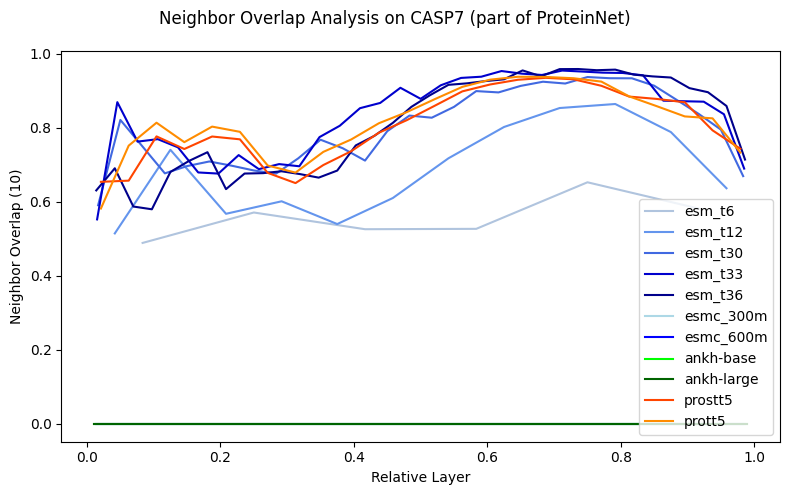

In [12]:
fig = plt.figure(figsize=(8, 5))
gs = gridspec.GridSpec(1, 1, figure=fig)
axs = [fig.add_subplot(gs[0])]
plot_metric(axs[0], ROOT, "casp7", relative=True, legend=False, metric="noverlap")
axs[0].set_title(None)
axs[0].legend(loc="lower right")
fig.suptitle("Neighbor Overlap Analysis on CASP7 (part of ProteinNet)")
fig.tight_layout()
fig.savefig("figures/casp_analysis.png", dpi=300)
fig.savefig("figures/casp_analysis.pdf", dpi=300)
plt.show()

## Plots on SCOPe40 2.08

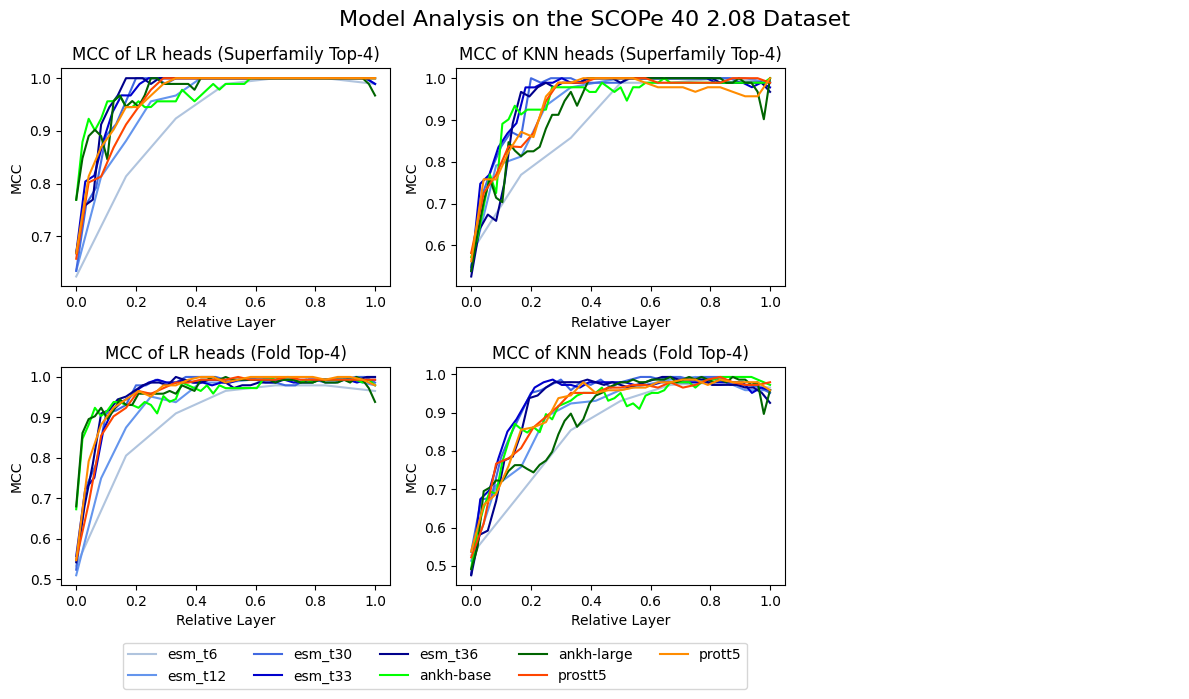

In [13]:
fig = plt.figure(figsize=(12, 7))
gs = gridspec.GridSpec(2, 3, figure=fig)
axs = [
    fig.add_subplot(gs[0, 0]), fig.add_subplot(gs[0, 1]), fig.add_subplot(gs[0, 2]),
    fig.add_subplot(gs[1, 0]), fig.add_subplot(gs[1, 1]), fig.add_subplot(gs[1, 2]),
]

plot_scope_top4_metric(axs[0], "lr", CLASS_METRIC, "superfamily", True)
plot_scope_top4_metric(axs[1], "knn", CLASS_METRIC, "superfamily", True)
plot_scope_top4_metric(axs[3], "lr", CLASS_METRIC, "fold", True)
plot_scope_top4_metric(axs[4], "knn", CLASS_METRIC, "fold", True)
axs[2].set_axis_off()
axs[5].set_axis_off()

handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="lower center", bbox_to_anchor=(11/30, 0), bbox_transform=fig.transFigure, ncol=(len(MODELS) - 1) // 2)  # -0.08

fig.suptitle(f"Model Analysis on the SCOPe 40 2.08 Dataset", fontsize=16)
plt.tight_layout(rect=[0, 0.075, 1, 1])
plt.savefig(f"figures/scope_analysis.pdf")
plt.savefig(f"figures/scope_analysis.png")
plt.show()

Plotting SCOPe analysis for superfamily level ...


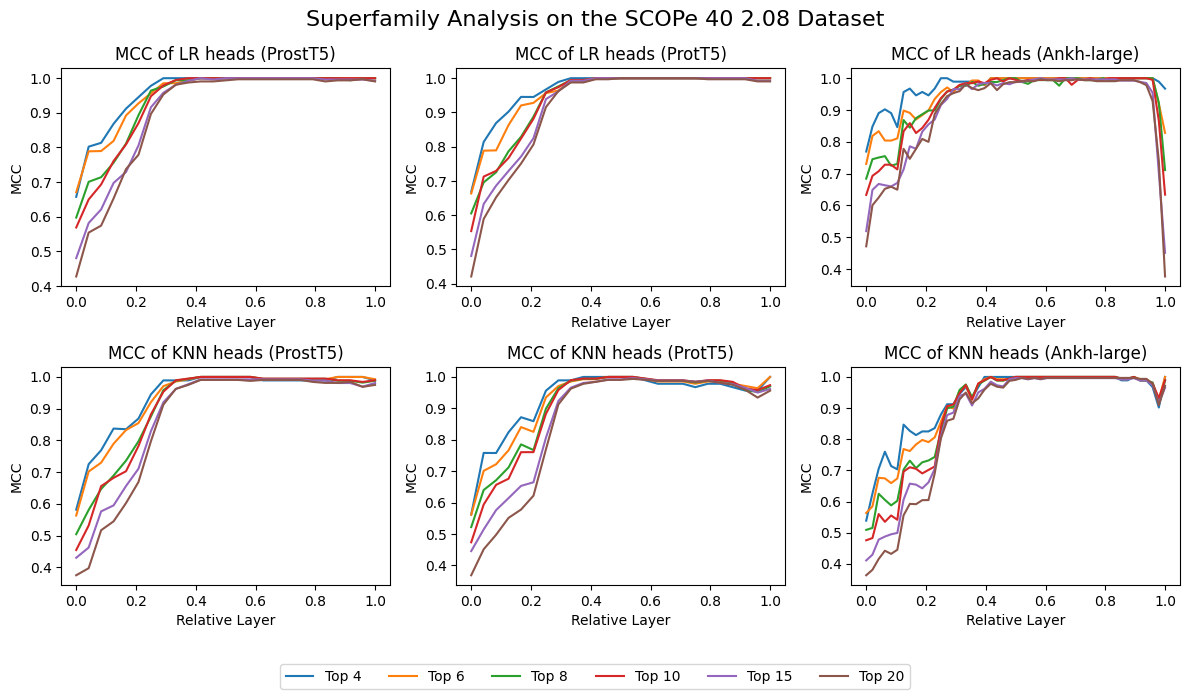

Plotting SCOPe analysis for fold level ...


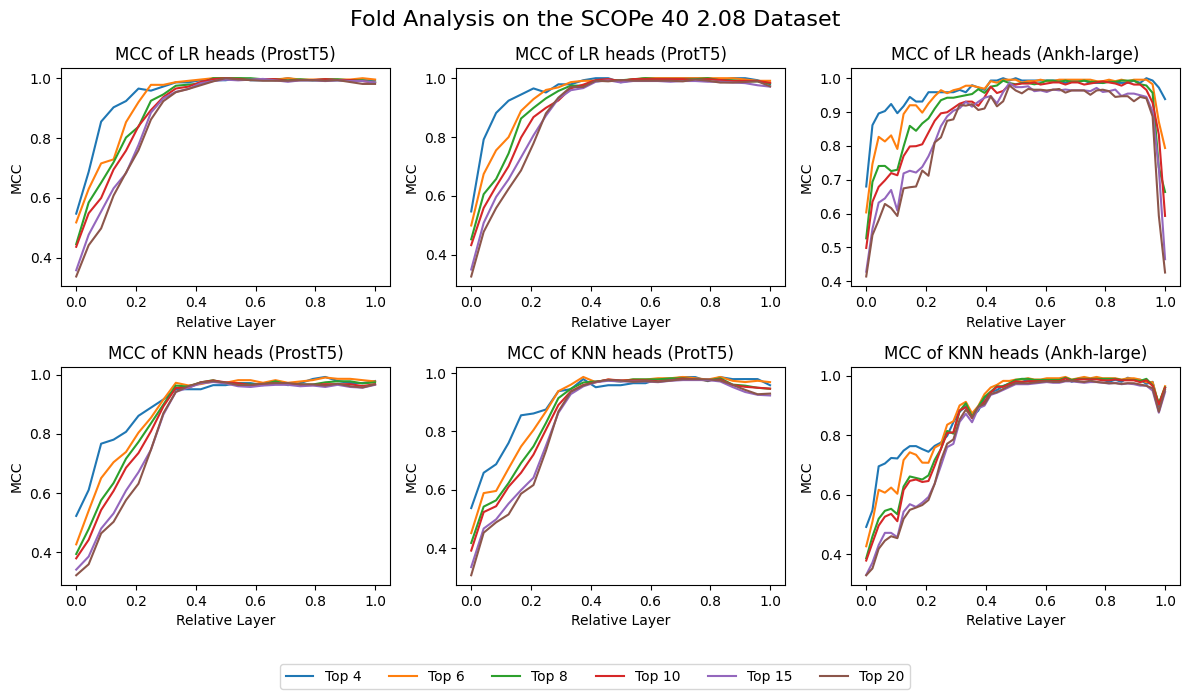

In [14]:
for level in ["superfamily", "fold"]:
    print(f"Plotting SCOPe analysis for {level} level ...")
    fig = plt.figure(figsize=(12, 7))
    gs = gridspec.GridSpec(2, 3, figure=fig)
    axs = [
        fig.add_subplot(gs[0, 0]), fig.add_subplot(gs[0, 1]), fig.add_subplot(gs[0, 2]),
        fig.add_subplot(gs[1, 0]), fig.add_subplot(gs[1, 1]), fig.add_subplot(gs[1, 2]),
    ]
    
    plot_scope_topX_metric(axs[0], "prostt5", "lr", CLASS_METRIC, level, True)
    plot_scope_topX_metric(axs[1], "prott5", "lr", CLASS_METRIC, level, True)
    plot_scope_topX_metric(axs[2], "ankh-large", "lr", CLASS_METRIC, level, True)
    plot_scope_topX_metric(axs[3], "prostt5", "knn", CLASS_METRIC, level, True)
    plot_scope_topX_metric(axs[4], "prott5", "knn", CLASS_METRIC, level, True)
    plot_scope_topX_metric(axs[5], "ankh-large", "knn", CLASS_METRIC, level, True)

    handles, labels = axs[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc="lower center", bbox_to_anchor=(15/30, 0), bbox_transform=fig.transFigure, ncol=len(MODELS))  # -0.08

    fig.suptitle(f"{level.capitalize()} Analysis on the SCOPe 40 2.08 Dataset", fontsize=16)
    plt.tight_layout(rect=[0, 0.075, 1, 1])
    plt.savefig(f"figures/scope_perf_{level}.pdf")
    plt.savefig(f"figures/scope_perf_{level}.png")
    plt.show()

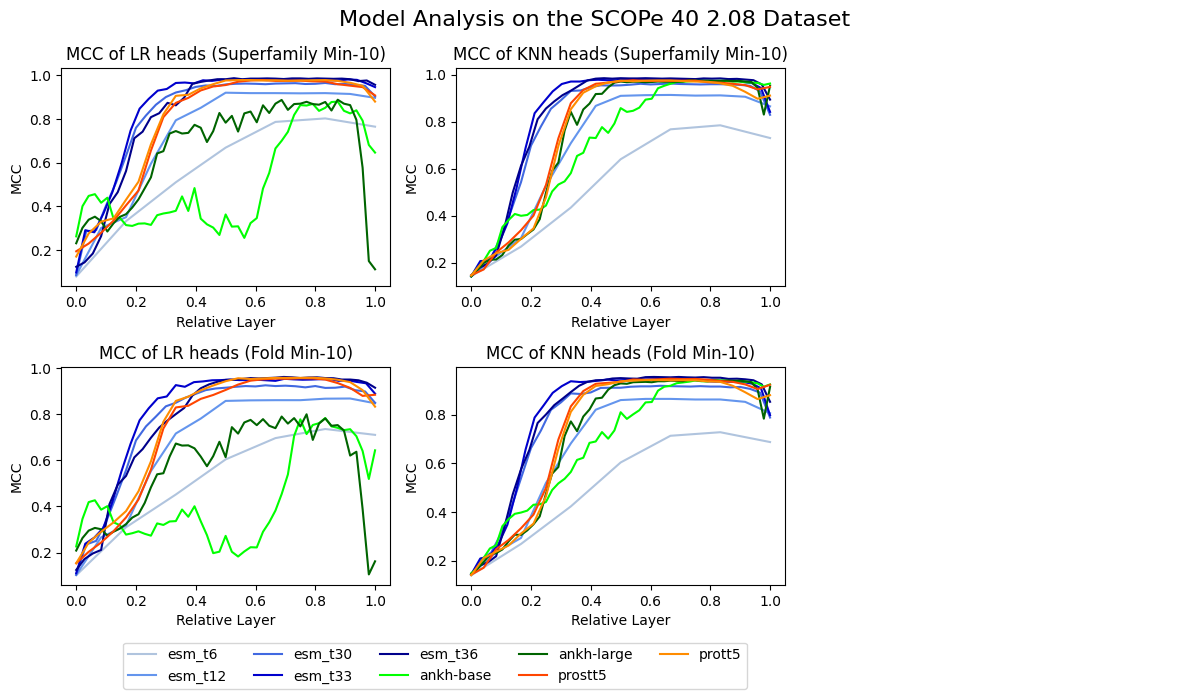

In [15]:
fig = plt.figure(figsize=(12, 7))
gs = gridspec.GridSpec(2, 3, figure=fig)
axs = [
    fig.add_subplot(gs[0, 0]), fig.add_subplot(gs[0, 1]), fig.add_subplot(gs[0, 2]),
    fig.add_subplot(gs[1, 0]), fig.add_subplot(gs[1, 1]), fig.add_subplot(gs[1, 2]),
]

plot_scope_minx_metric(axs[0], "lr", CLASS_METRIC, "superfamily", True)
plot_scope_minx_metric(axs[1], "knn", CLASS_METRIC, "superfamily", True)
plot_scope_minx_metric(axs[3], "lr", CLASS_METRIC, "fold", True)
plot_scope_minx_metric(axs[4], "knn", CLASS_METRIC, "fold", True)
axs[2].set_axis_off()
axs[5].set_axis_off()

handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="lower center", bbox_to_anchor=(11/30, 0), bbox_transform=fig.transFigure, ncol=(len(MODELS) - 1) // 2)  # -0.08

fig.suptitle(f"Model Analysis on the SCOPe 40 2.08 Dataset", fontsize=16)
plt.tight_layout(rect=[0, 0.075, 1, 1])
plt.savefig(f"figures/scope_analysis.pdf")
plt.savefig(f"figures/scope_analysis.png")
plt.show()

Plotting SCOPe analysis for superfamily level ...


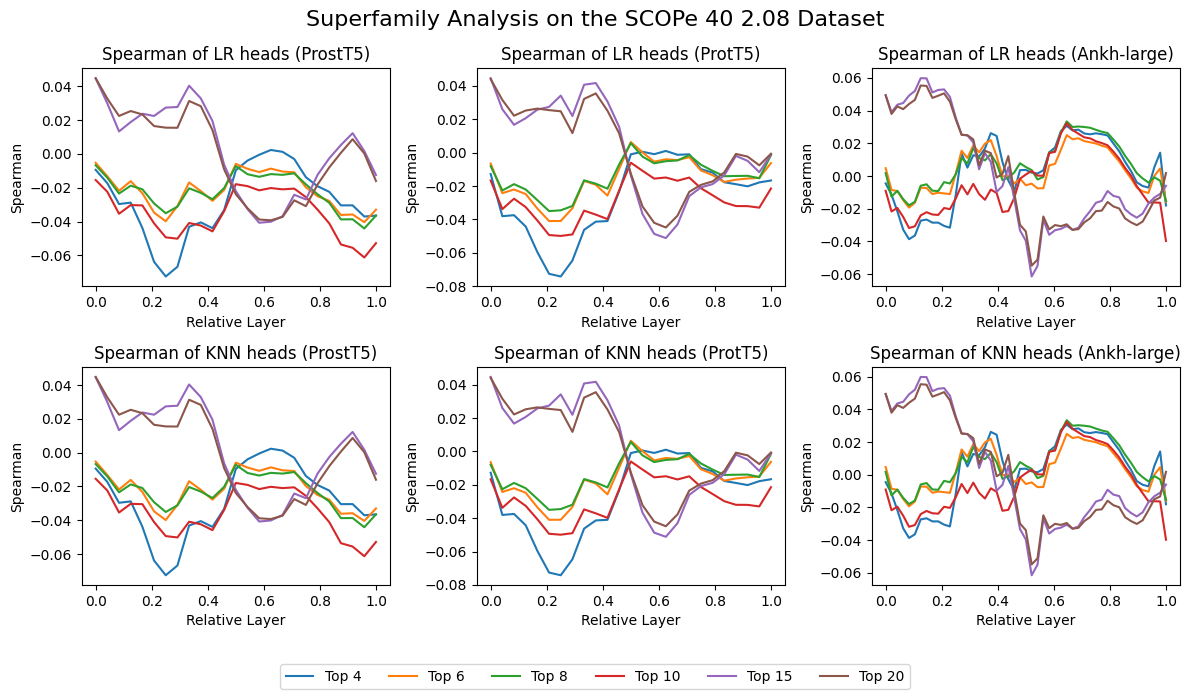

Plotting SCOPe analysis for fold level ...


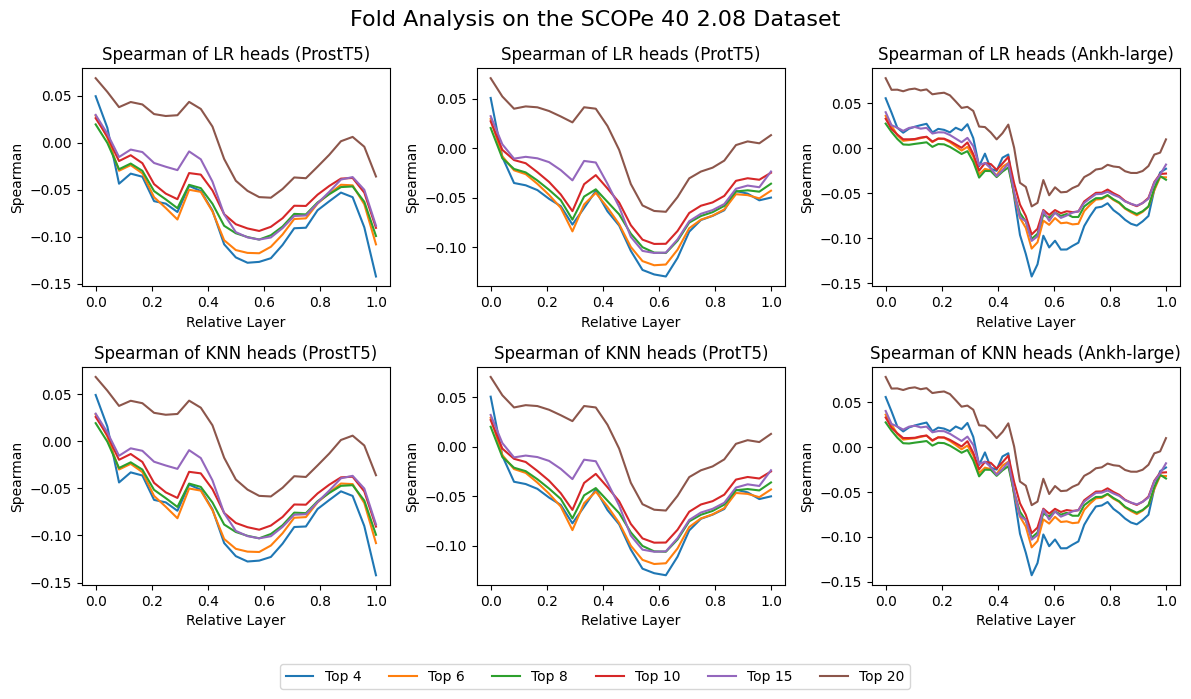

In [16]:
for level in ["superfamily", "fold"]:
    print(f"Plotting SCOPe analysis for {level} level ...")
    fig = plt.figure(figsize=(12, 7))
    gs = gridspec.GridSpec(2, 3, figure=fig)
    axs = [
        fig.add_subplot(gs[0, 0]), fig.add_subplot(gs[0, 1]), fig.add_subplot(gs[0, 2]),
        fig.add_subplot(gs[1, 0]), fig.add_subplot(gs[1, 1]), fig.add_subplot(gs[1, 2]),
    ]

    plot_scope_topX_metric(axs[0], "prostt5", "lr", "spearman", level, True, True)
    plot_scope_topX_metric(axs[1], "prott5", "lr", "spearman", level, True, True)
    plot_scope_topX_metric(axs[2], "ankh-large", "lr", "spearman", level, True, True)
    plot_scope_topX_metric(axs[3], "prostt5", "knn", "spearman", level, True, True)
    plot_scope_topX_metric(axs[4], "prott5", "knn", "spearman", level, True, True)
    plot_scope_topX_metric(axs[5], "ankh-large", "knn", "spearman", level, True, True)

    handles, labels = axs[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc="lower center", bbox_to_anchor=(15/30, 0), bbox_transform=fig.transFigure, ncol=len(MODELS))  # -0.08

    fig.suptitle(f"{level.capitalize()} Analysis on the SCOPe 40 2.08 Dataset", fontsize=16)
    plt.tight_layout(rect=[0, 0.075, 1, 1])
    plt.savefig(f"figures/scope_corr_{level}.pdf")
    plt.savefig(f"figures/scope_corr_{level}.png")
    plt.show()

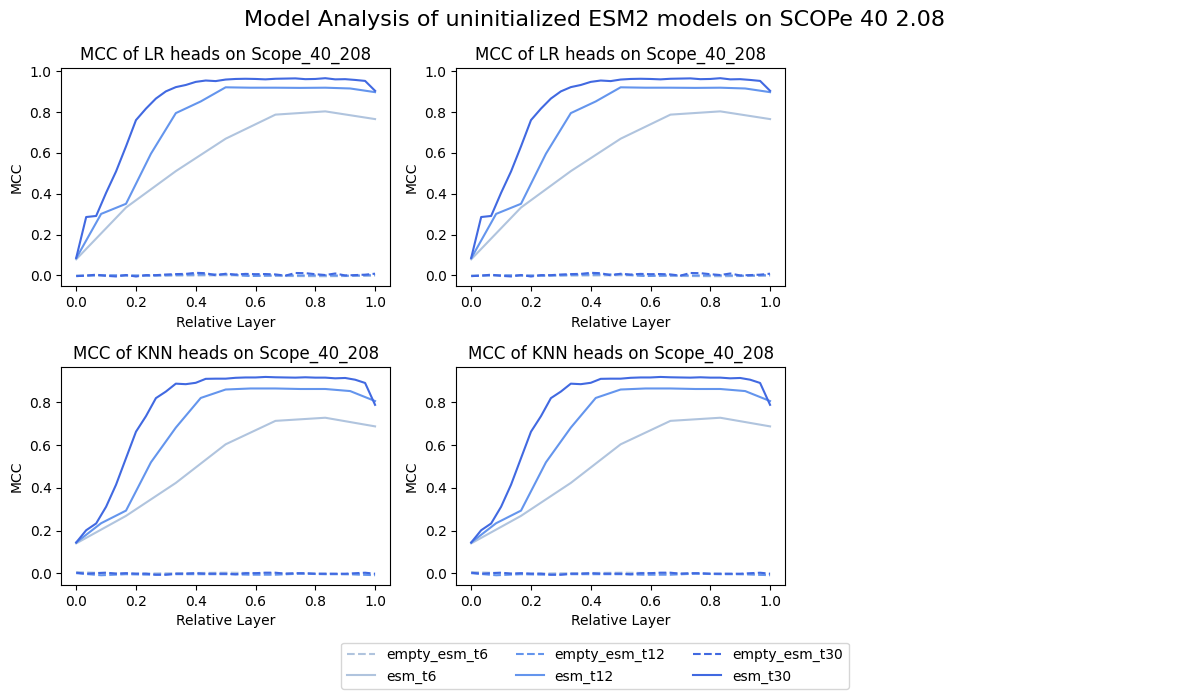

In [17]:
fig = plt.figure(figsize=(12, 7))
gs = gridspec.GridSpec(2, 3, figure=fig)
axs = [
    fig.add_subplot(gs[0, 0]), fig.add_subplot(gs[0, 1]), fig.add_subplot(gs[0, 2]),
    fig.add_subplot(gs[1, 0]), fig.add_subplot(gs[1, 1]), fig.add_subplot(gs[1, 2]),
]

plot_empty_scope(axs[0], ROOT, "scope_40_208", ["esm_t6", "esm_t12", "esm_t30"], "lr", CLASS_METRIC, level="superfamily")
plot_empty_scope(axs[1], ROOT, "scope_40_208", ["esm_t6", "esm_t12", "esm_t30"], "lr", CLASS_METRIC, level="superfamily")
kill_axis(axs[2])
plot_empty_scope(axs[3], ROOT, "scope_40_208", ["esm_t6", "esm_t12", "esm_t30"], "knn", CLASS_METRIC, level="fold")
plot_empty_scope(axs[4], ROOT, "scope_40_208", ["esm_t6", "esm_t12", "esm_t30"], "knn", CLASS_METRIC, level="fold")
kill_axis(axs[5])

handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="lower center", bbox_to_anchor=(0.5, 0), bbox_transform=fig.transFigure, ncol=3)  # -0.08


fig.suptitle(f"Model Analysis of uninitialized ESM2 models on SCOPe 40 2.08", fontsize=16)
plt.tight_layout(rect=[0, 0.075, 1, 1])
plt.savefig(f"figures/empty_analysis_scope.pdf")
plt.savefig(f"figures/empty_analysis_scope.png")
plt.show()

## Summary Plots for Local vs. Global Analysis

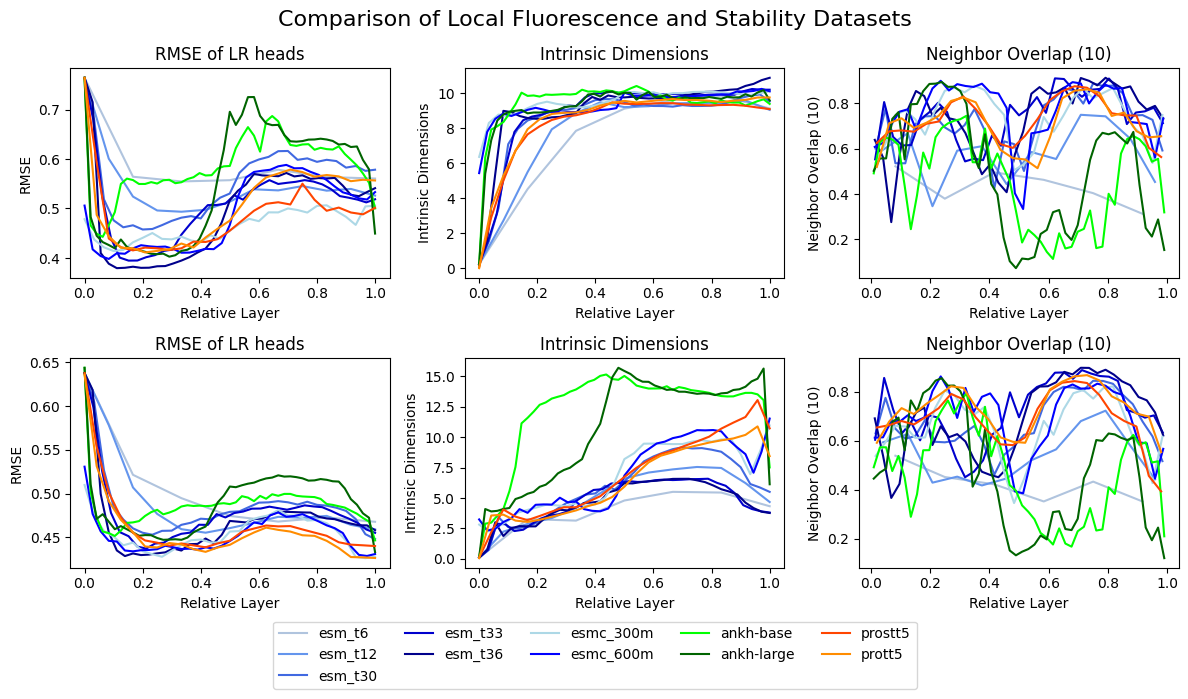

In [25]:
fig = plt.figure(figsize=(12, 7))
gs = gridspec.GridSpec(2, 3, figure=fig)
axs = [
    fig.add_subplot(gs[0, 0]), fig.add_subplot(gs[0, 1]), fig.add_subplot(gs[0, 2]),
    fig.add_subplot(gs[1, 0]), fig.add_subplot(gs[1, 1]), fig.add_subplot(gs[1, 2]),
]

plot_performance(axs[0], ROOT, "fluorescence", "lr", REG_METRIC, relative=True, legend=False)
plot_metric(axs[1], ROOT, "fluorescence", relative=True, legend=False, metric="ids")
plot_metric(axs[2], ROOT, "fluorescence", relative=True, legend=False, metric="noverlap")

plot_performance(axs[3], ROOT, "stability",  "lr", REG_METRIC, relative=True, legend=False)
plot_metric(axs[4], ROOT, "stability", relative=True, legend=False, metric="ids")
plot_metric(axs[5], ROOT, "stability", relative=True, legend=False, metric="noverlap")

handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="lower center", bbox_to_anchor=(0.5, 0), bbox_transform=fig.transFigure, ncol=5)  # -0.08

fig.suptitle(f"Comparison of Local Fluorescence and Stability Datasets", fontsize=16)
plt.tight_layout(rect=[0, 0.1, 1, 1])
plt.savefig(f"figures/summary1.pdf")
plt.savefig(f"figures/summary1.png")
plt.show()

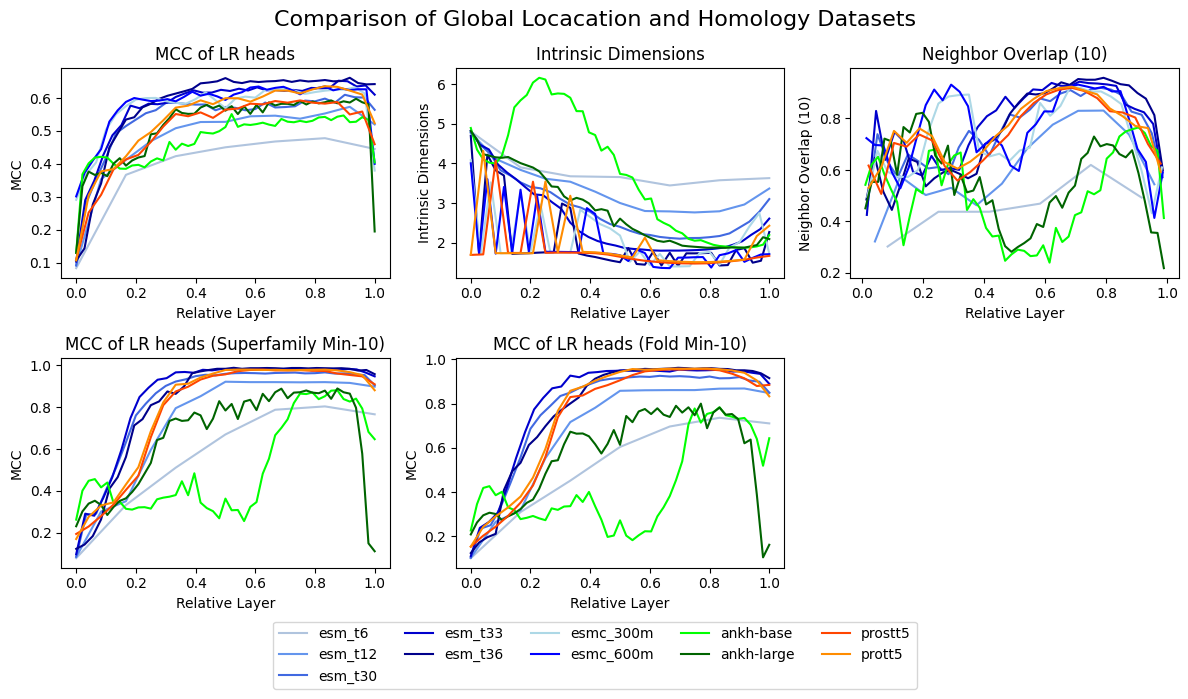

In [26]:
fig = plt.figure(figsize=(12, 7))
gs = gridspec.GridSpec(2, 3, figure=fig)
axs = [
    fig.add_subplot(gs[0, 0]), fig.add_subplot(gs[0, 1]), fig.add_subplot(gs[0, 2]),
    fig.add_subplot(gs[1, 0]), fig.add_subplot(gs[1, 1]), fig.add_subplot(gs[1, 2]),
]

plot_performance(axs[0], ROOT, "deeploc2", "lr", CLASS_METRIC, relative=True, legend=False)
plot_metric(axs[1], ROOT, "deeploc2", relative=True, legend=False, metric="ids")
plot_metric(axs[2], ROOT, "deeploc2", relative=True, legend=False, metric="noverlap")
plot_scope_minx_metric(axs[3], "lr", CLASS_METRIC, "superfamily", True)
plot_scope_minx_metric(axs[4], "lr", CLASS_METRIC, "fold", True)
kill_axis(axs[5])

handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="lower center", bbox_to_anchor=(0.5, 0), bbox_transform=fig.transFigure, ncol=5)  # -0.08

fig.suptitle(f"Comparison of Global Locacation and Homology Datasets", fontsize=16)
plt.tight_layout(rect=[0, 0.1, 1, 1])
plt.savefig(f"figures/summary2.pdf")
plt.savefig(f"figures/summary2.png")
plt.show()

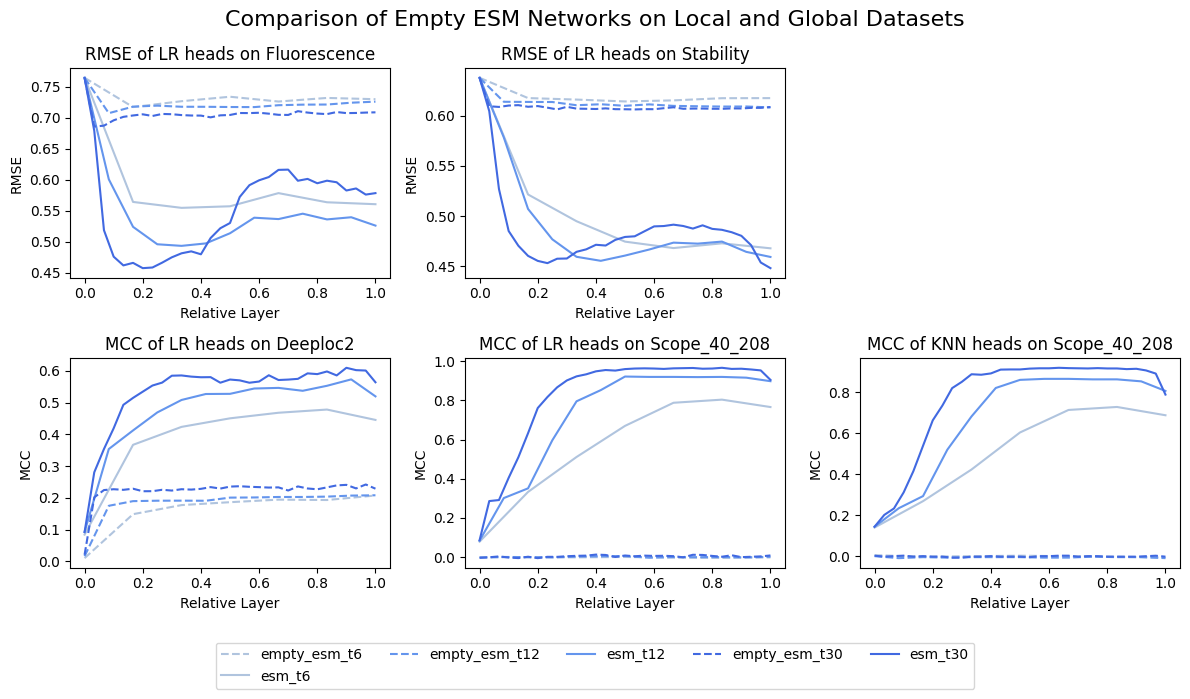

In [27]:
fig = plt.figure(figsize=(12, 7))
gs = gridspec.GridSpec(2, 3, figure=fig)
axs = [
    fig.add_subplot(gs[0, 0]), fig.add_subplot(gs[0, 1]), fig.add_subplot(gs[0, 2]),
    fig.add_subplot(gs[1, 0]), fig.add_subplot(gs[1, 1]), fig.add_subplot(gs[1, 2]),
]

plot_empty(axs[0], ROOT, "fluorescence", ["esm_t6", "esm_t12", "esm_t30"], "lr", REG_METRIC)
plot_empty(axs[1], ROOT, "stability", ["esm_t6", "esm_t12", "esm_t30"], "lr", REG_METRIC)
kill_axis(axs[2])
plot_empty(axs[3], ROOT, "deeploc2", ["esm_t6", "esm_t12", "esm_t30"], "lr", CLASS_METRIC)
plot_empty_scope(axs[4], ROOT, "scope_40_208", ["esm_t6", "esm_t12", "esm_t30"], "lr", CLASS_METRIC, level="superfamily")
plot_empty_scope(axs[5], ROOT, "scope_40_208", ["esm_t6", "esm_t12", "esm_t30"], "knn", CLASS_METRIC, level="fold")

handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="lower center", bbox_to_anchor=(0.5, 0), bbox_transform=fig.transFigure, ncol=5)  # -0.08

fig.suptitle(f"Comparison of Empty ESM Networks on Local and Global Datasets", fontsize=16)
plt.tight_layout(rect=[0, 0.1, 1, 1])
plt.savefig(f"figures/summary3.pdf")
plt.savefig(f"figures/summary3.png")
plt.show()

## Suspended plots

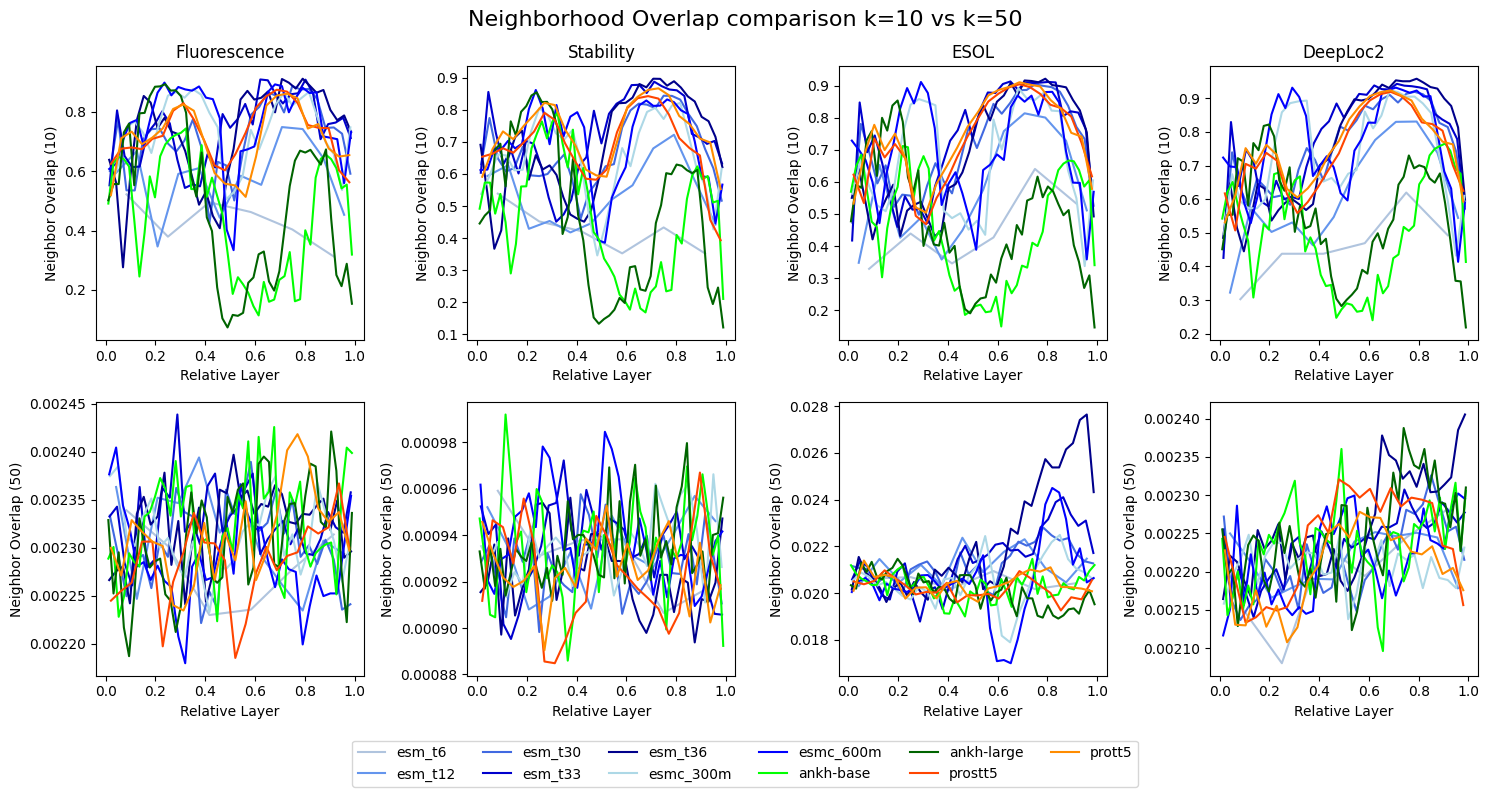

: 

In [ ]:
fig = plt.figure(figsize=(15, 8))
gs = gridspec.GridSpec(2, 4, figure=fig)
axs = [
    fig.add_subplot(gs[0, 0]), fig.add_subplot(gs[0, 1]), fig.add_subplot(gs[0, 2]), fig.add_subplot(gs[0, 3]),
    fig.add_subplot(gs[1, 0]), fig.add_subplot(gs[1, 1]), fig.add_subplot(gs[1, 2]), fig.add_subplot(gs[1, 3]),
]
plot_metric(axs[0], ROOT, "fluorescence", relative=True, legend=False, metric="noverlap")
plot_metric(axs[1], ROOT, "stability", relative=True, legend=False, metric="noverlap")
plot_metric(axs[2], ROOT, "esol", relative=True, legend=False, metric="noverlap")
plot_metric(axs[3], ROOT, "deeploc2", relative=True, legend=False, metric="noverlap")
plot_metric(axs[4], ROOT, "fluorescence", relative=True, legend=False, metric="noverlap_50")
plot_metric(axs[5], ROOT, "stability", relative=True, legend=False, metric="noverlap_50")
plot_metric(axs[6], ROOT, "esol", relative=True, legend=False, metric="noverlap_50")
plot_metric(axs[7], ROOT, "deeploc2", relative=True, legend=False, metric="noverlap_50")
axs[0].set_title("Fluorescence")
axs[1].set_title("Stability")
axs[2].set_title("ESOL")
axs[3].set_title("DeepLoc2")
axs[4].set_title("")
axs[5].set_title("")
axs[6].set_title("")
axs[7].set_title("")

handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="lower center", bbox_to_anchor=(0.5, 0), bbox_transform=fig.transFigure, ncol=(len(MODELS) + 1) // 2)  # -0.08

fig.suptitle(f"Neighborhood Overlap comparison k=10 vs k=50", fontsize=16)
plt.tight_layout(rect=[0, 0.075, 1, 1])
plt.savefig(f"figures/noverlap_analysis.pdf")
plt.savefig(f"figures/noverlap_analysis.png")
plt.show()